In [34]:
import matplotlib.pylab as plt
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
import random

In [35]:
# hyperparameters
split = (0.85);
sequence_length = 10;
epochs = 100
learning_rate = 0.02


In [36]:
# loading stock price and news data
data = pd.read_csv("./dataset/BERT_sentiment_withprices.csv")
stock_column = ['prices']
news_column = ['sentiment']

len_stock_data = data.shape[0]

In [37]:
data.shape[0]

2076

In [38]:
# splitting data to train and test
train_examples = int(len_stock_data * split)
train = data.get(stock_column).values[:train_examples]
train_sentiment = data.get(news_column).values[:train_examples]
test = data.get(stock_column).values[train_examples:]
test_sentiment = data.get(news_column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]
len_train_sentiment = train_sentiment.shape[0]
len_test_sentiment = test_sentiment.shape[0]


In [39]:
# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)


# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
    
len_X_train = len(X_train)
y_train = np.array(train[sequence_length:]).astype(float)


# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
len_X_test = len(X_test)
y_test = np.array(test[sequence_length:]).astype(float)


# adding news sentiment to train and test
for i in range(len_X_train):
    X_train[i] = X_train[i].tolist()
    X_train[i].append(train_sentiment[sequence_length + i].tolist())
X_train = np.array(X_train).astype(float)

for i in range(len_X_test):
    X_test[i] = X_test[i].tolist()
    X_test[i].append(test_sentiment[sequence_length + i].tolist())
X_test = np.array(X_test).astype(float)

In [40]:
import joblib
joblib.dump(scaler, "scaler/scaler_v2.pkl")

['scaler/scaler_v2.pkl']

In [41]:
test[0]

array([0.])

In [42]:
len(y_test)

302

In [43]:
#creating LSTM model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 70, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 10, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
        metrics=['accuracy']
    )

    # The history is returning only loss and val_loss because the model is not configured to track accuracy.
    # To include accuracy metrics, we need to specify them in the model.compile() step.
    # Since this is outside the current selection, we'll add a comment explaining the issue.
    
    # Note: To fix this, update the model.compile() step to include 'accuracy' in metrics:
    # model.compile(
    #     loss=tf.keras.losses.MeanSquaredError(),
    #     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    #     metrics=['accuracy']
    # )
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        # batch_size=4,
        # verbose=1  # Added verbose=1 to show training progress
    )
    
    # After training, you can check available metrics:
    print("Available metrics:", history.history.keys())
    return model, history

In [44]:
def plot_accuracy(history):
    print(history.history)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    # plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    # plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [45]:
# inverting normaliztion
y_test = scaler.inverse_transform(y_test)

# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions


# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    
    return mae, mape, (1 - mape)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 3.8917e-04 - loss: 0.0363
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 3.8917e-04 - loss: 0.0014
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 3.8917e-04 - loss: 0.0013
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 3.8917e-04 - loss: 0.0013
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 3.8917e-04 - loss: 0.0012
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 3.8917e-04 - loss: 9.7598e-04
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 3.8917e-04 - loss: 7.3293e-04
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 3.8917e-04 - loss: 6.0141e-04
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 3.8917e-04 - loss: 5.5147e-04
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 3.8917e-04 - loss: 5.4264e-04
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 3.8917e-04 - loss: 5.2300

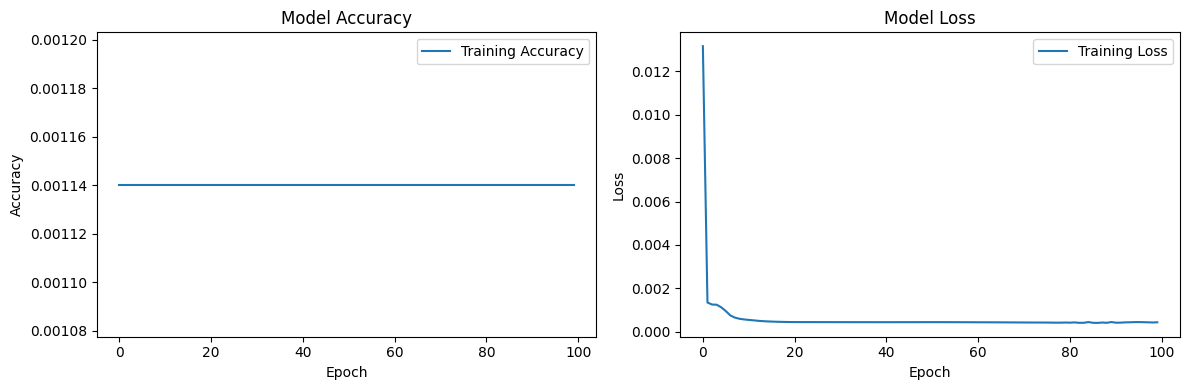

Mean Absolute Error = 1240.012714714404
Mean Absolute Percentage Error = 0.02136808896884689%
Accuracy = 0.9786319110311531


In [46]:
# trial runs
def run_model(n):
    total_mae = total_mape = total_acc = 0
    for i in range(n):
        model, history = model_create()
        predictions = predict(model)
        mae, mape, acc = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc 
        plot_accuracy(history)
        # # Save Model
        # model.save("models/price_model_v1.keras")
    return model, (total_mae / n), (total_mape / n), (total_acc / n), predictions


model, mae, mape, acc, predictions = run_model(1)

print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")

In [47]:
model.save("models/price_model_v2.keras")

In [48]:
# Mean Absolute Error = 586.1096942608175
# Mean Absolute Percentage Error = 0.01694061087149177%
# Accuracy = 0.9830593891285082

### Analysis


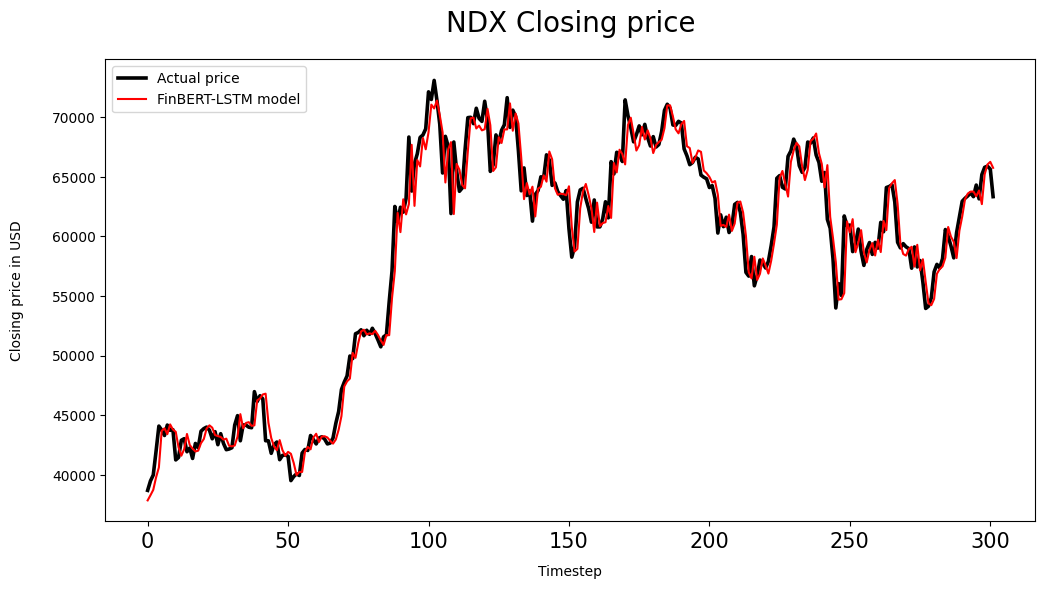

In [49]:
plt.figure(figsize=(12, 6))

plt.plot(y_test, linewidth = 2.6, color = "black")
plt.plot(predictions, color = "red")

plt.xlabel("Timestep", fontsize = 10, labelpad = 10)
plt.xticks(fontsize = 15)
plt.ylabel("Closing price in USD", fontsize = 10, labelpad = 20)
plt.title("NDX Closing price", fontsize = 20, pad = 20)
plt.legend(['Actual price', 'FinBERT-LSTM model'], loc='upper left')

plt.show()

Run Model and predict 10 days

Data preprocessing is done, time to input it into the model

In [66]:
import keras
def predict_prices(x, model, scale):
     predictions = model.predict(x)
     predictions = scale.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
     return predictions

Get random numbers and add it to array to plot graph

In [88]:
def run_random_test(epoc):
     real_predictions = []
     random_presictions = []
     # Import model
     price_model = keras.models.load_model('models/price_model_v1.keras')
     test_scaler = joblib.load("scaler/scaler.pkl")
     
     
     for i in range(epoc):
          random_number = random.randint(0, 2000)
          prices = data.get(stock_column).values[random_number:random_number+10]
          y_price =  data.get(stock_column).values[random_number+1]
          real_predictions.append(y_price[0])
          prices_sentiment = data.get(news_column).values[random_number:random_number+11]

          prices = test_scaler.transform(prices)
          
          # splitting testing data to x and y
          X_prices = [prices[0 : 10]]
          
          X_prices[0] = X_prices[0].tolist()
          X_prices[0].append(prices_sentiment[-1].tolist())
          X_prices = np.array(X_prices).astype(float)
          
          
          price_prediction = predict_prices(X_prices, price_model, test_scaler)
          # prediction on test set
          random_presictions.append(price_prediction[0][0])
          
     plt.figure(figsize=(12, 6))

     plt.plot(real_predictions, marker="+", color = "black")
     plt.plot(random_presictions, marker="+", color = "red")

     plt.xlabel("Timestep", fontsize = 10, labelpad = 10)
     plt.xticks(fontsize = 15)
     plt.ylabel("Closing price in USD", fontsize = 10, labelpad = 20)
     plt.title("NDX Closing price", fontsize = 20, pad = 20)
     plt.legend(['Actual price', 'FinBERT-LSTM model'], loc='upper left')
     plt.grid()

     plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

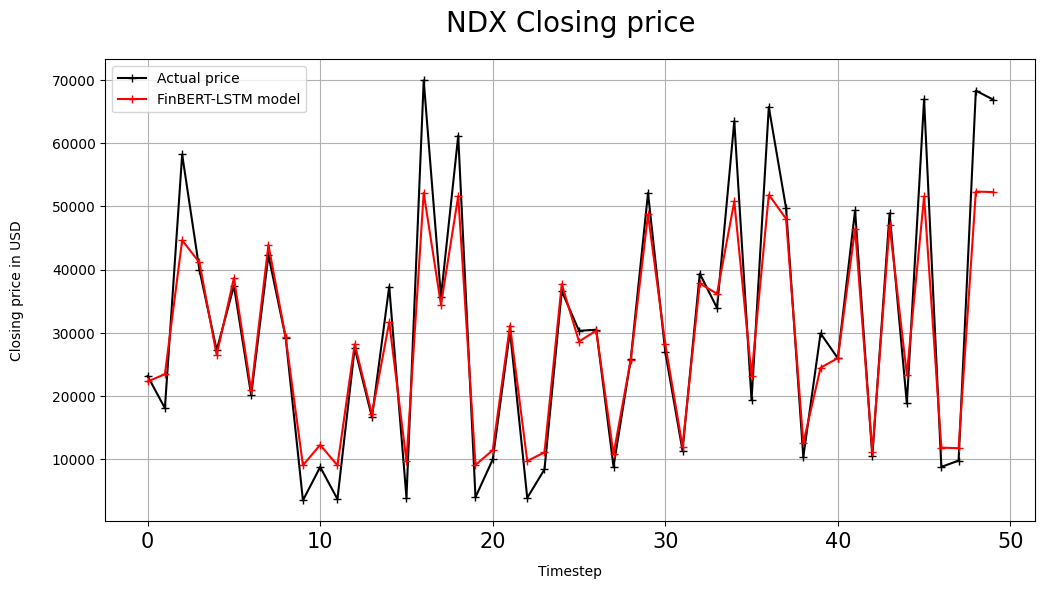

In [89]:
run_random_test(50)

In [100]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load the scaler
scaler = joblib.load("scaler/scaler_v2.pkl")

# Load the new data
new_data = pd.read_csv("./dataset/BERT_sentiment_withprices.csv")

# Filter data for the required date (e.g., the last 10 days before 2024-10-21)
# Assuming the date column is named 'date' and is in datetime format
new_data['date'] = pd.to_datetime(new_data['date'])
target_date = pd.to_datetime('2024-10-21')
previous_data = new_data[(new_data['date'] < target_date)].tail(10)  # Get last 10 days

# Extract prices and sentiment
prices = previous_data['prices'].values
sentiments = previous_data['sentiment'].values

# Normalize the data
normalized_prices = scaler.transform(prices.reshape(-1, 1))
normalized_sentiments = sentiments.reshape(-1, 1)

# Prepare the input for the model
X_new = []
if len(normalized_prices) >= sequence_length:  # Check if there are enough prices
    for i in range(len(normalized_prices)):
        X_new.append(np.append(normalized_prices[i:i + sequence_length], normalized_sentiments[sequence_length + i]))

X_new = np.array(X_new).astype(float)

print(X_new)
# Reshape X_new for LSTM input
X_new = X_new.reshape((X_new.shape[0], X_new.shape[1], 1))

print(X_new)
if X_new.size == 0:
     raise ValueError("X_new is empty. Check the input data and sequence length.")

# Load the trained model
model = tf.keras.models.load_model("models/price_model_v2.keras")

# Make predictions
predictions = model.predict(X_new)

# Invert normalization
predicted_prices = scaler.inverse_transform(predictions.reshape(-1, 1))

# Output the predicted price for 2024-10-21
print(f"Predicted BTC Price for 2024-10-21: {predicted_prices[-1][0]}")

IndexError: index 10 is out of bounds for axis 0 with size 10